In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [79]:
df_raw = pd.read_csv("mortgage.csv")
df_raw = df_raw[df_raw["LTV_time"].notna()]
df_raw.shape

(622219, 23)

## Data Preparation

In [80]:
def select_data(data, cutoff):
    cand_id = (data["id"].value_counts() > cutoff).sort_index().index[(data["id"].value_counts() > cutoff).sort_index()].tolist()
    res = pd.merge(data, pd.DataFrame({"id": cand_id}), on="id")
    df_default = res[["id", "default_time"]].groupby("id").agg("sum").reset_index().rename(columns={"default_time":"default"})
    df_default["default"][df_default["default"] > 1] = 1
    res = pd.merge(res, df_default, on="id")
    res = res.groupby("id").tail(cutoff)
    res["mat_orig_diff"] = res["mat_time"] - res["orig_time"]
    res = res.drop(["time", "orig_time", "first_time", "mat_time", "default_time", "payoff_time", "status_time"], axis=1)
    
    return res, df_default

In [81]:
df, df_default = select_data(df_raw, 15)
df.shape[0]/15

13849.0

### Visualization

In [82]:
def pie_penct(labels, sizes):
    colors = ['lightcoral', 'lightskyblue', 'yellowgreen', 'gold']
    plt.figure(figsize=(10,8))
    plt.pie(sizes, explode=(0.1, 0), labels=labels, colors=colors[0:len(labels)], autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()

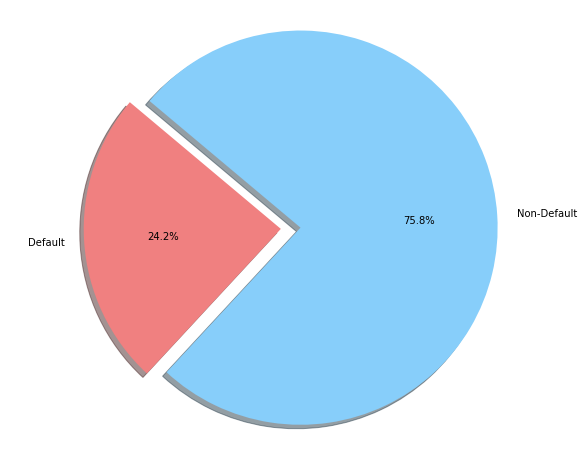

In [83]:
pie_penct(["Default", "Non-Default"], [df_default["default"].sum(), (df_default["default"]==0).sum()])

### Train/Test ID split

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
def data_split(df, df_default):
    id_train, id_test = train_test_split(df_default, test_size = .25, random_state = 123, stratify = df_default["default"])
    df_train = pd.merge(df, id_train, on="id").drop("default_y", axis=1).rename(columns={"default_x": "default"})
    df_test = pd.merge(df, id_test, on="id").drop("default_y", axis=1).rename(columns={"default_x": "default"})
    return df_train, df_test

In [86]:
df_train, df_test = data_split(df, df_default)

### Aggregation Data for Other Models

In [87]:
def agg_data(df):
    return df.groupby("id").agg("mean").reset_index()

In [88]:
### Save Aggregation Train/Test Data
train_agg = agg_data(df_train)
test_agg = agg_data(df_test)

train_agg.to_csv("Train.csv", index=False)
test_agg.to_csv("Test.csv", index=False)

In [89]:
def create_Xy(df_train, df_test, n=15):
    '''create X and y'''
    X_train = df_train.drop(["id", "default"], axis=1).as_matrix().reshape(int(df_train.shape[0]/n), n, df_train.shape[1] - 2)
    X_test = df_test.drop(["id", "default"], axis=1).as_matrix().reshape(int(df_test.shape[0]/n), n, df_test.shape[1] - 2)
    print("X_train's shape: ", X_train.shape)
    print("X_test's shape: ", X_test.shape)
    y_train = np.array(df_train[["id", "default"]].drop_duplicates()["default"].tolist())
    y_test = np.array(df_test[["id", "default"]].drop_duplicates()["default"].tolist())
    
    return X_train, y_train, X_test, y_test

In [90]:
X_train, y_train, X_test, y_test = create_Xy(df_train, df_test)

X_train's shape:  (10386, 15, 16)
X_test's shape:  (3463, 15, 16)


## RNN Model

In [91]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [174]:
model = Sequential()
model.add(LSTM(32, input_shape=(15, 16), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
#model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

# compile
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"])

# earlystop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=30, verbose=1, mode='auto')
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
callbacks_list = [earlystop, checkpoint]

history = model.fit(X_train, y_train, batch_size=512, epochs=500, validation_split=.2, callbacks=callbacks_list)

Train on 8308 samples, validate on 2078 samples
Epoch 1/500
8308/8308 [==============================] - 5s 621us/step - loss: 0.5261 - acc: 0.7382 - val_loss: 0.5180 - val_acc: 0.7406

Epoch 00001: val_acc improved from -inf to 0.74062, saving model to weights.best.hdf5
Epoch 2/500
8308/8308 [==============================] - 2s 252us/step - loss: 0.4807 - acc: 0.7583 - val_loss: 0.5428 - val_acc: 0.7507

Epoch 00002: val_acc improved from 0.74062 to 0.75072, saving model to weights.best.hdf5
Epoch 3/500
8308/8308 [==============================] - 2s 270us/step - loss: 0.4799 - acc: 0.7599 - val_loss: 0.4941 - val_acc: 0.7401

Epoch 00003: val_acc did not improve from 0.75072
Epoch 4/500
8308/8308 [==============================] - 2s 267us/step - loss: 0.4734 - acc: 0.7608 - val_loss: 0.5010 - val_acc: 0.7416

Epoch 00004: val_acc did not improve from 0.75072
Epoch 5/500
8308/8308 [==============================] - 2s 273us/step - loss: 0.4766 - acc: 0.7630 - val_loss: 0.4954 - val_

8308/8308 [==============================] - 2s 282us/step - loss: 0.5032 - acc: 0.7715 - val_loss: 0.5511 - val_acc: 0.7560

Epoch 00043: val_acc did not improve from 0.77238
Epoch 44/500
8308/8308 [==============================] - 2s 246us/step - loss: 0.5301 - acc: 0.7746 - val_loss: 0.5453 - val_acc: 0.7464

Epoch 00044: val_acc did not improve from 0.77238
Epoch 45/500
8308/8308 [==============================] - 2s 252us/step - loss: 0.5309 - acc: 0.7673 - val_loss: 0.5475 - val_acc: 0.7502

Epoch 00045: val_acc did not improve from 0.77238
Epoch 46/500
8308/8308 [==============================] - 2s 262us/step - loss: 0.5152 - acc: 0.7622 - val_loss: 0.5474 - val_acc: 0.7430

Epoch 00046: val_acc did not improve from 0.77238
Epoch 47/500
8308/8308 [==============================] - 2s 276us/step - loss: 0.4743 - acc: 0.7606 - val_loss: 0.5085 - val_acc: 0.7425

Epoch 00047: val_acc did not improve from 0.77238
Epoch 48/500
8308/8308 [==============================] - 2s 253us/s

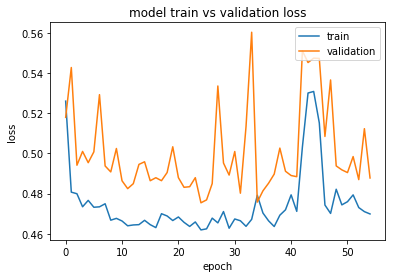

In [175]:
# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [176]:
y_pred_RNN_lstm3 = model.predict(X_test)

In [171]:
y_pred_RNN_gru3 = model.predict(X_test)

In [166]:
y_pred_RNN_simple3 = model.predict(X_test)

In [160]:
y_pred_RNN_simple2 = model.predict(X_test)

In [154]:
y_pred_RNN_gru2 = model.predict(X_test)

In [148]:
y_pred_RNN_lstm2 = model.predict(X_test)

In [142]:
y_pred_RNN_lstm1 = model.predict(X_test)

In [ ]:
y_pred_RNN_gru1 = model.predict(X_test)

In [96]:
y_pred_RNN_simple1 = model.predict(X_test)

In [119]:
from sklearn.metrics import roc_curve, auc

def plt_roc(y_true, df_pred):
    plt.figure(figsize=(10,8))
    colors = ['cyan','red','fuchsia','aqua','lime','coral','orange','violet','yellow','purple']
    for i in range(df_pred.shape[1]):
        fpr, tpr, _ = roc_curve(y_true, df_pred.iloc[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], 
                 lw=1.5, label='%s (AUC = %0.3f)' % (df_pred.iloc[:,i].name, roc_auc))
        
    plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [177]:
df_RNN = pd.DataFrame({"Simple-1": y_pred_RNN_simple1[:,0], "GRU-1": y_pred_RNN_gru1[:,0], "LSTM-1": y_pred_RNN_lstm1[:,0],
                       "Simple-2": y_pred_RNN_simple2[:,0], "GRU-2": y_pred_RNN_gru2[:,0], "LSTM-2": y_pred_RNN_lstm2[:,0],
                       "Simple-3": y_pred_RNN_simple3[:,0], "GRU-3": y_pred_RNN_gru3[:,0], "LSTM-3": y_pred_RNN_lstm3[:,0]})

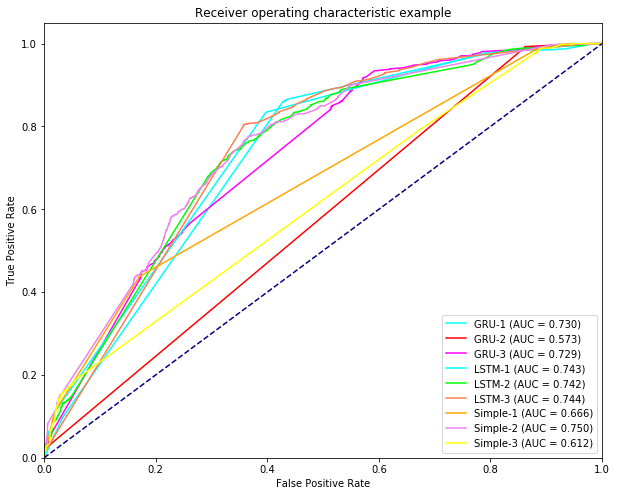

In [178]:
plt_roc(y_test, df_RNN)

# Other Models

In [2]:
df_train = pd.read_csv("Train.csv").drop("id", axis=1)
df_test = pd.read_csv("Test.csv").drop("id", axis=1)

X_train = df_train.drop("default", axis=1)
X_test = df_test.drop("default", axis=1)
y_train = df_train["default"].values
y_test = df_test["default"].values

## Logistic Regression

In [3]:
res = pd.read_csv("logistic_result.csv").rename(columns={"y_pred1": "Logistic", "y_pred2": "WeightedLogistic",
                                                         "X1": "l1-logistic", "X1.1": "l2-logistic"})

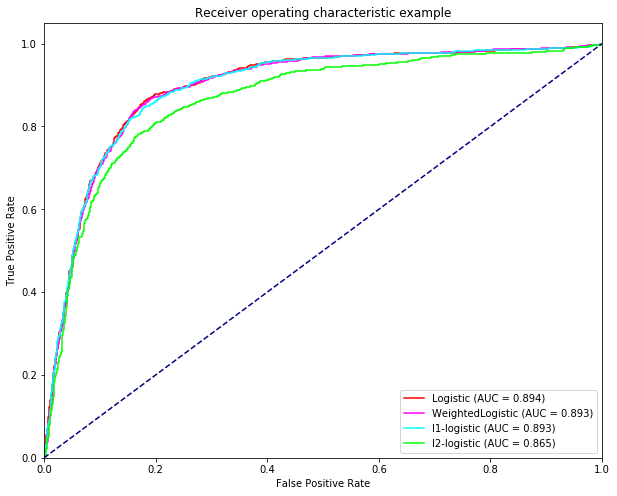

In [5]:
plt_roc(y_test, res)

## KNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def knn(k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    return neigh.predict_proba(X_test)[:, 1]

In [7]:
df_knn = pd.DataFrame()
for i in [3,5,9,13,17,23,27,33,37,43]:
    df_knn["k=%d"%i] = knn(i)

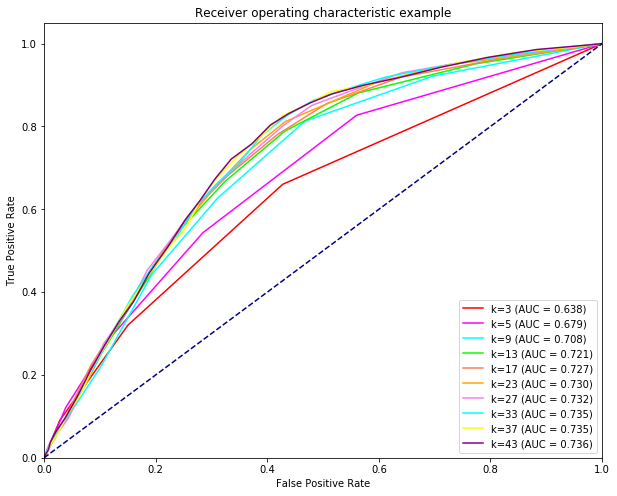

In [8]:
plt_roc(y_test, df_knn)

## SVM

In [9]:
%%time
from sklearn.svm import SVC
df_svm = pd.DataFrame()
for i in ["rbf", "sigmoid"]:
    clf = SVC(kernel=i, probability=True)
    clf.fit(X_train, y_train)
    df_svm["kernel %s"%i] = clf.predict_proba(X_test)[:,1]

CPU times: user 58.6 s, sys: 1.15 s, total: 59.8 s
Wall time: 59.8 s


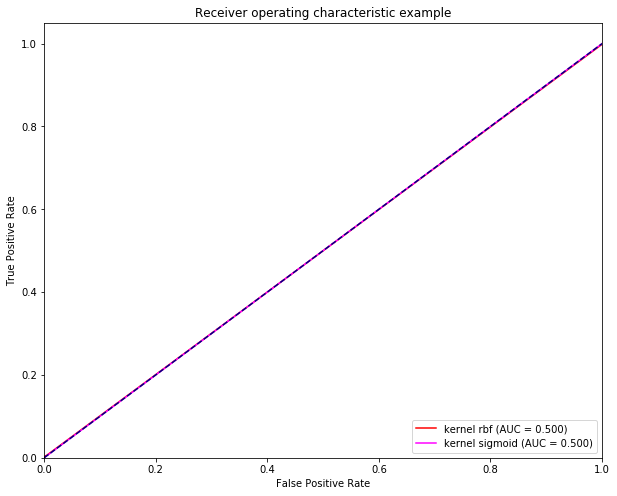

In [10]:
plt_roc(y_test, df_svm)

## LightGBM

In [11]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, y_train)
dtest = lgb.Dataset(X_test, y_test)

In [62]:
params = {
    'boosting_type': 'rf',
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

In [63]:
gbm = lgb.train(params, dtrain, num_boost_round=1000)
y_pred_rf = gbm.predict(X_test)

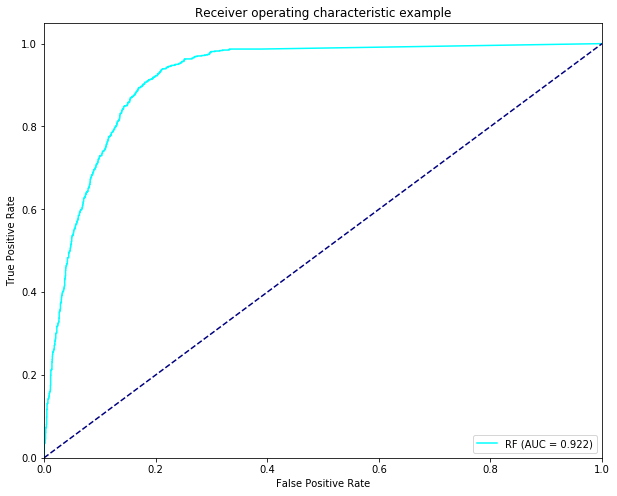

In [64]:
plt_roc(y_test, pd.DataFrame({"RF": y_pred_rf}))

In [71]:
import seaborn as sns
def fea_imp(bst, name):
    df_fetrImpt = pd.DataFrame({'feature': bst.feature_name(), name: bst.feature_importance()})
    sns.barplot(y='feature', x=name, data=df_fetrImpt.sort_values(by=name, ascending=False), orient='h')

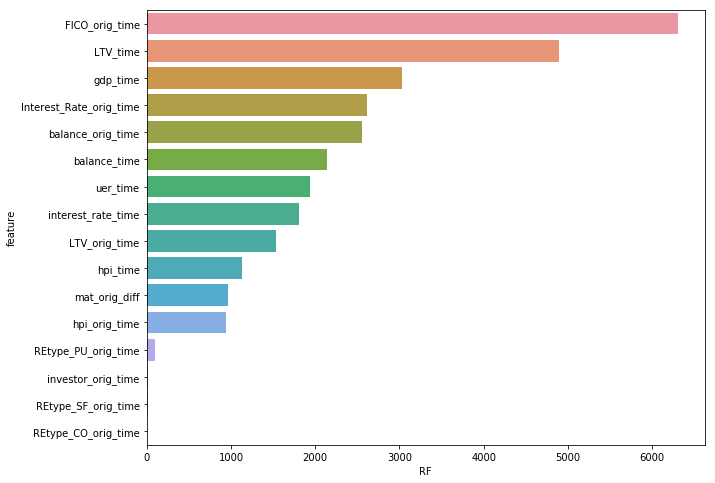

In [73]:
plt.figure(figsize=(10,8))
fea_imp(gbm, "RF")

In [67]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 51,
    #'max_depth': 7,
    #'min_data_in_leaf': 30,
    'learning_rate': 0.01,
    'lambda_l2': .1,
    'verbose': 1
}
gbm2 = lgb.train(params, dtrain, num_boost_round=1000)
y_pred_gbd = gbm2.predict(X_test)

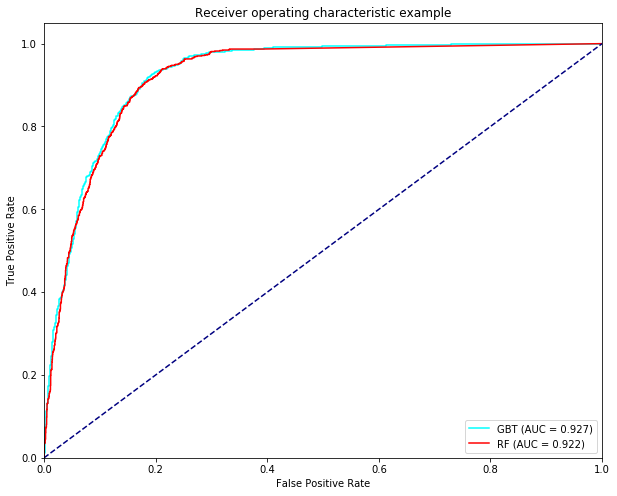

In [68]:
plt_roc(y_test, pd.DataFrame({"GBT": y_pred_gbd, "RF":y_pred_rf}))

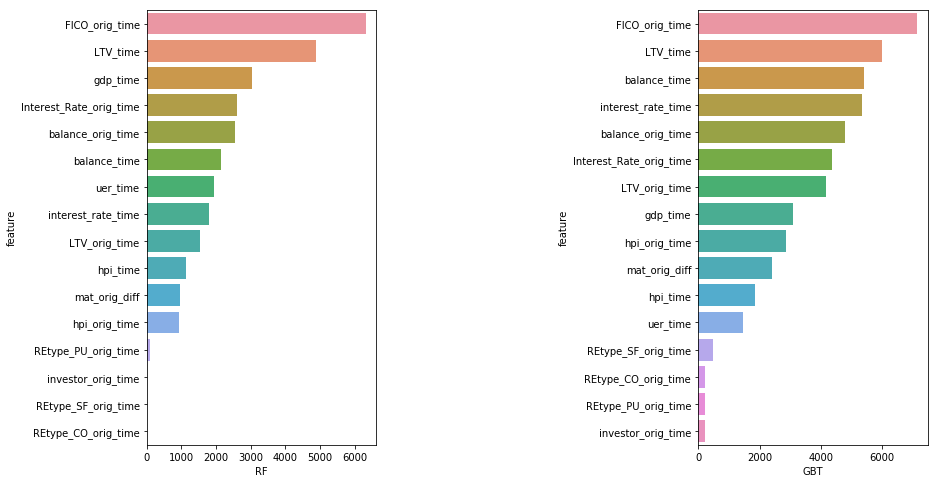

In [77]:
plt.figure(figsize=(14,8))
plt.subplot(1, 3, 1)
fea_imp(gbm, "RF")
plt.subplot(1, 3, 3)
fea_imp(gbm2, "GBT")